In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pathlib import Path
import pickle

from hyperopt import fmin, hp, tpe, STATUS_OK, Trials, space_eval

from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# import altair as alt
import mlflow

from sklearn.metrics import  make_scorer
from lightgbm import LGBMRanker, LGBMClassifier #, __version__
from lightgbm import plot_importance


from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score
average_precision_scorer = make_scorer(average_precision_score, average='weighted')  #, average = 'weighted')
roc_auc_scorer = make_scorer(roc_auc_score, average='weighted') #average = 'weighted')



idx = pd.IndexSlice
import pylab as plt
from utils import reduce_memory


In [2]:
# import sys
# sys.path.append('../')

from mlflow_utils import mlflow_log_model
from model import get_model
from metrics import METRICS, precision_at_85, recall_at_85

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [3]:
import boto3
boto3.session.Session().available_profiles

['se-stage',
 'se-prod',
 'zgdatalake',
 'zgdatalake-staging',
 'sedatalakeprodreadonly',
 'sedatalakeprodreadwrite',
 'sedatalakeadmin',
 'sedatalakestagingreadonly',
 'sedatalakestagingreadwrite',
 'sedatalakeadmin-stage',
 'default']

In [4]:
# boto3.setup_default_session(profile_name='sedatalakestagingreadwrite')
boto3.setup_default_session(profile_name='sedatalakeprodreadwrite')

## Load Data

In [5]:
X_train = pd.read_parquet('./data/train/X_train.parquet')
y_train = pd.read_parquet('./data/train/y_train.parquet').iloc[:, 0]

In [6]:
X_val = pd.read_parquet('./data/train/Xval.parquet')
y_val = pd.read_parquet('./data/train/yval.parquet').iloc[:, 0]

In [7]:
X_train.columns

Index(['spatial', 'days', 'price_pct_diff', 'partial_unit_score',
       'partial_street_score', 'same_unit', 'same_building_id', 'same_bin',
       'same_complex', 'candidates', 'same_zipcode', 'building_in_10',
       'same_unittype', 'x', 'y', 'distance', 'azimuth'],
      dtype='object')

#### Weights

In [8]:
X_train = reduce_memory(X_train)

Mem. usage decreased to 37.84 Mb (56.8%% reduction)


In [9]:
sample_weights = np.where(y_train, 5, 1)

## 1. Base Model

In [10]:
params = {'model__colsample_bytree': 0.5013544317317782,
 'model__min_child_samples': 51,
 'model__min_child_weight': 1e-05,
 'model__num_leaves': 21,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 5,
 'model__subsample': 0.4301443471481221
}


In [11]:
MODEL = get_model(LGBMClassifier).set_params(**params)

In [12]:
scoring={'average_precision': average_precision_scorer,
         'roc_auc': roc_auc_scorer,
         'precision_at_85': METRICS[-2],
         'recall_at_85': METRICS[-1]}

In [133]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

In [134]:

space ={
    'model__boosting_type': hp.choice('model__boosting_type', ['gbdt', 'dart', 'goss']),
    'model__class_weight': hp.choice('model__class_weight', [None, 'balanced']),
    'model__learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
     'model__subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
        'model__feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'model__bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'model__min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'model__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'model__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'model__verbose': -1,
        #the LGBM parameters docs list various aliases, and the LGBM implementation seems to complain about
        #the following not being used due to other params, so trying to silence the complaints by setting to None
        'model__subsample': None, #overridden by bagging_fraction
        'model__reg_alpha': None, #overridden by lambda_l1
        'model__reg_lambda': None, #overridden by lambda_l2
        'model__min_sum_hessian_in_leaf': None, #overrides min_child_weight
        'model__min_child_samples': None, #overridden by min_data_in_leaf
        'model__colsample_bytree': None, #overridden by feature_fraction
#        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
        'model__min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
#     'model__baggings_fraction': hp.uniform('model__bagging_fraction', 0.5, 1), 
#     'model__subsample_for_bin': hp.quniform('model__subsample_for_bin', 20000, 300000, 20000),
#     'model__max_depth': hp.uniformint('model__max_depth', 1, 30),
#     'model__max_bin': hp.uniformint('model__max_bin', 10, 1000),
#     'model__subsample': hp.uniform('model__subsample', 0.1, 1),
#     'model__min_child_samples': hp.quniform('model__min_child_samples', 20, 500, 5),
#     'model__min_child_weight': hp.uniform('model__min_child_weight', 0.001, 500),
#     'model__colsample_bytree': hp.uniform('model__colsample_bytree', 0.3, 0.9),
#     'model__min_gain_to_split': hp.uniformint('model__min_gain_to_split', 0,15),
#     'model__min_data_in_leaf': hp.uniformint('model__min_data_in_leaf', 5,300),
#     'preprocessor__ut__sigma': hp.uniform('preprocessor__ut__sigma', 0.05,0.6)
    
} 

In [135]:
trials = Trials()

In [151]:
# def recall_at_q(ytrue, yproba, q=0.9):
#     total = ytrue.sum()
#     if q < 0:
#         quantile = pd.Series(yproba).quantile(q)
#         return ytrue[yproba > quantile].sum()/ total
#     if q > 0:
#         v = yproba.nlargest(q)

In [150]:
y_train.sum() / 4

784.0

In [152]:
def objective(params):
    # Convert some hyperparameters to integers
    for col in 'model__min_data_in_leaf', 'model__max_depth': #'model__min_child_samples':
        if col in params:
            params[col] = int(params[col])
    for col in ('model__subsample_for_bin', ):
        if col in params:
            params[col] = int(float(params[col]))
    
    # model__estimator__random_state=2022 < for calibration
    model = clone(MODEL).set_params(**params, ) 
    metrics = cross_validate(model, X_train, y_train, cv=skf, 
                             params = {'model__sample_weight': sample_weights},
                             return_train_score=False,
                             scoring=scoring['roc_auc'])
    
    avg_metrics = pd.DataFrame(metrics).mean()
    metric = 'test_score'
    return {'loss': -1* avg_metrics[metric],
            'status':STATUS_OK, 'metrics':avg_metrics.to_dict()}

In [154]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=75, trials=trials, 
            verbose=1, rstate=np.random.default_rng(42))

100%|███████████████████████████████████████████████████████████████████████████████████████| 75/75 [09:58<00:00, 23.96s/trial, best loss: -0.9944955034863179]


In [155]:
best_params = space_eval(space, best)

for col in 'model__min_data_in_leaf', 'model__max_depth': #'model__min_child_samples':
    if col in best_params:
        best_params[col] = int(best_params[col])
for col in ('model__subsample_for_bin', ):
    if col in best_params:
        best_params[col] = int(float(best_params[col]))
        
best_params

{'model__bagging_fraction': 0.5913758206188472,
 'model__boosting_type': 'dart',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': None,
 'model__feature_fraction': 0.516377322490629,
 'model__lambda_l1': 0,
 'model__lambda_l2': 0,
 'model__learning_rate': 0.060621250695763136,
 'model__min_child_samples': None,
 'model__min_child_weight': 27.36587626451878,
 'model__min_data_in_leaf': 2,
 'model__min_sum_hessian_in_leaf': None,
 'model__reg_alpha': None,
 'model__reg_lambda': None,
 'model__subsample': None,
 'model__subsample_for_bin': 220000,
 'model__verbose': -1}

In [156]:
model_name = "lgbm_bcl_bl_w5"

with open(f"./models/trials/{model_name}.hyperopt", "wb") as f:
        pickle.dump(trials, f)

In [13]:
best_params = {'model__bagging_fraction': 0.5913758206188472,
 'model__boosting_type': 'dart',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': None,
 'model__feature_fraction': 0.516377322490629,
 'model__lambda_l1': 0,
 'model__lambda_l2': 0,
 'model__learning_rate': 0.060621250695763136,
 'model__min_child_samples': None,
 'model__min_child_weight': 27.36587626451878,
 'model__min_data_in_leaf': 2,
 'model__min_sum_hessian_in_leaf': None,
 'model__reg_alpha': None,
 'model__reg_lambda': None,
 'model__subsample': None,
 'model__subsample_for_bin': 220000,
 'model__verbose': -1}

## Performance on Validation

In [14]:
best_model = MODEL.set_params(**best_params, model__random_state=2024)
best_model.fit(X_train, y_train)

y_proba = best_model.predict_proba(X_val)[:, 1]
y_pred = best_model.predict(X_val)

In [16]:
treshold = 0.45

print(f"""
On validation, at Threshold={treshold:.2f}
- precision: {y_val[y_proba > treshold].mean():.3f}
- recall: {y_val[y_proba>treshold].sum() / y_val.sum():.3f}
""")


On validation, at Threshold=0.45
- precision: 0.393
- recall: 0.994



In [26]:
y_val.sum()

348

In [29]:
y_val[y_proba > treshold].mean()

0.3931818181818182

In [ ]:
print(f"""
On validation
- precision: {precision_score(y_val, y_pred):.4f}
- recall: {recall_score(y_val, y_pred):.4f}
""")

In [17]:
average_precision_score(y_val, y_proba)

0.6999574552038254

In [18]:
roc_auc_score(y_val, y_proba)

0.9991848532462384

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


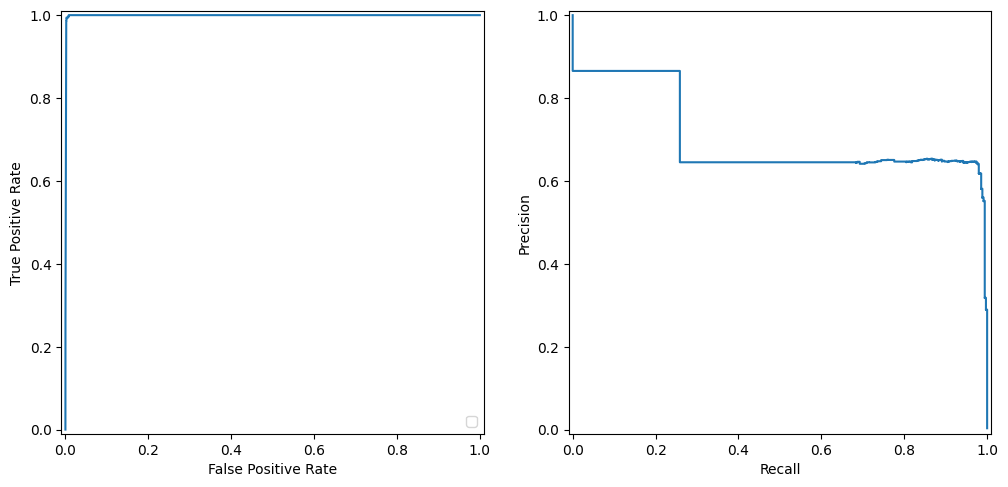

In [48]:
fpr, tpr, _ = roc_curve(y_val, y_proba, pos_label=1)
prec, recall, _ = precision_recall_curve(y_val, y_proba, pos_label=1)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### Threshold Curve

In [49]:
prec, recall, step = precision_recall_curve(y_val, y_proba, pos_label=1)

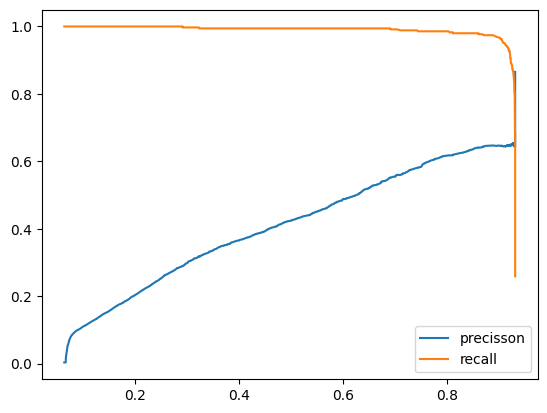

In [50]:
pd.DataFrame({'precisson':prec[:-1], 'recall':recall[:-1]}, index=step).plot();

### Calibration

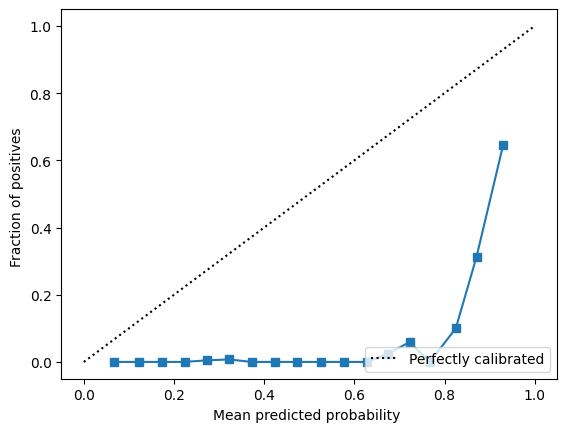

In [51]:
prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()

## Calibrated Model

In [52]:
cparams = { 
        'method': 'sigmoid',
#         'method': 'isotonic',
            'ensemble':True,
            'ensemble':False,
            'cv': 4}

In [53]:
calibrated = CalibratedClassifierCV(best_model, **cparams)
calibrated.fit(X_train, y_train)

2024/03/29 13:26:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5744ff693d0043348e31dfde1ab35802', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/03/29 13:28:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://streeteasy-datalake/research/mlflow/793/5744ff693d0043348e31dfde1ab35802/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2024/03/29 13:28:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 5744ff693d0043348e31dfde1ab35802. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Param

CalibratedClassifierCV(cv=4, ensemble=False,
                       estimator=Pipeline(steps=[('model',
                                                  LGBMClassifier(bagging_fraction=0.5913758206188472,
                                                                 boosting_type='dart',
                                                                 class_weight='balanced',
                                                                 colsample_bytree=None,
                                                                 feature_fraction=0.516377322490629,
                                                                 lambda_l1=0,
                                                                 lambda_l2=0,
                                                                 learning_rate=0.060621250695763136,
                                                                 min_child_samples=None,
                                                                 min_child_weight=27.36587626451878,
                                                                 min_data_in_leaf=2,
                                                                 min_sum_hessian_in_leaf=None,
                                                                 num_leaves=21,
                                                                 random_state=2024,
                                                                 reg_alpha=None,
                                                                 reg_lambda=None,
                                                                 subsample=None,
                                                                 subsample_for_bin=220000,
                                                                 verbose=-1))]))

In [30]:
calibrated

NameError: name 'calibrated' is not defined

In [54]:
y_pred_c = calibrated.predict_proba(X_val)[:, 1]
y_c = calibrated.predict(X_val)

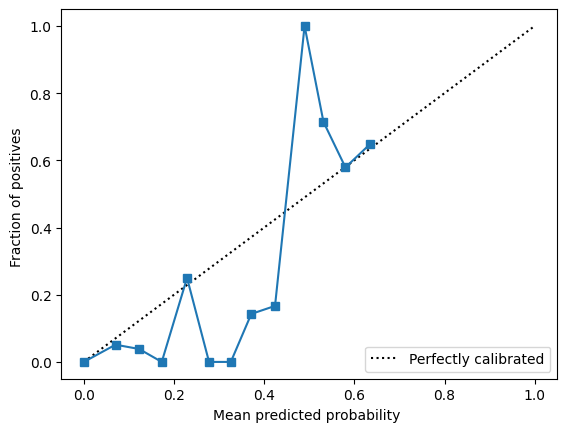

In [55]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_c, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_c)
disp.plot()

## TO METAFLOW

In [56]:
metaflow_config = dict(
    tracking_uri='https://mlflow.production.streeteasy.cloud',
    experiment_name='expert_transaction_matching',
    model_name='expert_transaction_matching',
    tags=dict(target='matching')
)

In [74]:
METRICS

[make_scorer(average_precision_score, response_method='predict', average=weighted),
 make_scorer(roc_auc_score, response_method='predict', average=weighted),
 make_scorer(precision_at_f, response_method='predict_proba'),
 make_scorer(recall_at_f, response_method='predict_proba'),
 make_scorer(recall_at_85, response_method='predict_proba'),
 make_scorer(precision_at_85, response_method='predict_proba')]

In [73]:
metaflow_config['run_name'] = 'binary_lbgm_bool_w_hp'

mlflow_log_model(
    calibrated,
    X_train,
    y_train,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':7},
    validation=(X_val, y_val, METRICS),
    upload_model=True
)

2024/03/29 13:33:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/29 13:33:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/29 13:35:58 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under s3://streeteasy-datalake/research/mlflow/793/4bb2dade607043d2b1efb03d0fc10522/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2024/03/29 13:35:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4bb2dade607043d2b1efb03d0fc10522. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Param value \'[(\'model\', LGBMClassifier(bagging_fraction=0.59137582061884

CalibratedClassifierCV(cv=4, ensemble=False,
                       estimator=Pipeline(steps=[('model',
                                                  LGBMClassifier(bagging_fraction=0.5913758206188472,
                                                                 boosting_type='dart',
                                                                 class_weight='balanced',
                                                                 colsample_bytree=None,
                                                                 feature_fraction=0.516377322490629,
                                                                 lambda_l1=0,
                                                                 lambda_l2=0,
                                                                 learning_rate=0.060621250695763136,
                                                                 min_child_samples=None,
                                                                 min_child_weight=27.36587626451878,
                                                                 min_data_in_leaf=2,
                                                                 min_sum_hessian_in_leaf=None,
                                                                 num_leaves=21,
                                                                 random_state=2024,
                                                                 reg_alpha=None,
                                                                 reg_lambda=None,
                                                                 subsample=None,
                                                                 subsample_for_bin=220000,
                                                                 verbose=-1))]))

## Backfill Ramifications

In [58]:
data = pd.read_parquet('./data/train/data.parquet')
X = pd.read_parquet('./data/train/X.parquet')
y = pd.read_parquet('./data/train/y.parquet').iloc[:, 0]

In [59]:
prob = calibrated.predict_proba(X)[:, 1]
data['probability'] = prob

In [60]:
cols = ['trxn_id', 'sale_id', 
#         'correct_sale_id', 
        'probability',
        'days','spatial', 'listing_unit', 'listing_street',
        'listing_zip',  'closing_unit',  'closing_street' ,
        'trxn_zip', 'trxn_price', 'listing_price']

# + features

In [61]:
already_matched = data['correct_sale_id'].notnull()

In [62]:
# MASK = (prob > 0.41) & (~already_matched)

In [63]:
results = dict()

for thld in np.arange(0.1, 1, 0.05):
    MASK = (prob > thld) & (~already_matched)
    results[thld] = MASK.sum()

In [64]:
pd.Series(results)

0.10    2126
0.15    2047
0.20    1986
0.25    1940
0.30    1903
0.35    1861
0.40    1814
0.45    1778
0.50    1760
0.55    1716
0.60    1628
0.65       0
0.70       0
0.75       0
0.80       0
0.85       0
0.90       0
0.95       0
dtype: int64

<Axes: >

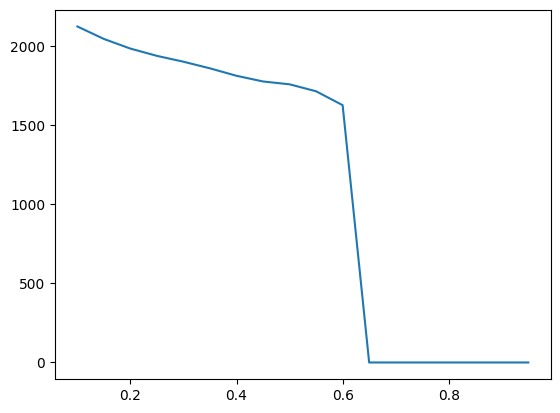

In [65]:
pd.Series(results).plot()

In [66]:
MASK = (prob >= 0.45) & (~already_matched)

In [67]:
MASK.sum()

1778

In [70]:
data['matched'] = data['sale_id'] == data['correct_sale_id']

In [68]:
data.loc[MASK, cols].sort_values('probability', ascending=False).tail(10)

,trxn_id,sale_id,probability,days,spatial,listing_unit,listing_street,listing_zip,closing_unit,closing_street,trxn_zip,trxn_price,listing_price
1733,3037.0,1577219.0,0.489073,0.0,33.0,3H,269 BENNETT AVENUE,10040,3H,4523 Broadway,10040,371000.0,379000.0
83,73.0,1462140.0,0.486972,5.0,78.0,21H,330 EAST 33 STREET,10016,21H,330 East 33 Street,,585000.0,579000.0
1210,80.0,1451452.0,0.483270,-21.0,94.0,2F,259 BENNETT AVENUE,10040,2F,259 Bennett Avenue,,350000.0,355000.0
17,18.0,1398433.0,0.477066,40.0,135.0,11F,225 Adams Street,11201,11F,225 Adams Street,,510000.0,525000.0
203,6997.0,1687507.0,0.472499,-32.0,5.0,501,435 TOMPKINS AVENUE,11216,501,435 Tompkins Avenue,11216,758000.0,778000.0
1692,2998.0,1570904.0,0.464141,3.0,75.0,3CN,150 CHARLES STREET,10014,3CN,150 Charles,10014,4500000.0,4995000.0
3363,5173.0,1621456.0,0.462065,13.0,0.0,LC,3845 SHORE PARKWAY,11235,LC,"3845 Shore Parkway (#LC), Brooklyn, NY",11235,180000.0,189999.0
2604,3520.0,1601666.0,0.458487,-56.0,0.0,3,657 PROSPECT PLACE,11216,3,657 Prospect Place,11216,890000.0,849000.0
5391,6073.0,1661813.0,0.458487,-68.0,0.0,4A,83 UNDERHILL AVENUE,11238,4A,83 Underhill Avenue,11238,735000.0,699000.0
3625,5250.0,1639620.0,0.456040,-22.0,0.0,16,249 EAST 50 STREET,10022,16,249 East 50th Street,10022,3600000.0,3999900.0
